# --- Day 14: Disk Defragmentation ---

In [1]:
import unittest
import numpy as np
import operator
from functools import reduce

In [2]:
input_str = 'hwlqcszp'
#input_str = 'flqrgnkx'
input_strings = [input_str + f'-{i}' for i in range(128)]

In [3]:
def mklengths(s):
    return list(map(ord, s)) + [17, 31, 73, 47, 23]

In [4]:
class Ring(object):
    def __init__(self, size=256):
        self.l = np.arange(size)
        self.len = size
        self.cur = 0
        self.skip = 0

    def checksum(self):
        return self.l[0] * self.l[1]
    
    def knot(self, length):
        # bring the current to the hed of the list
        tmp = np.roll(self.l, -self.cur)
        #print(f'1> {tmp}')
        # reverse the elements
        tmp[0:length] = tmp[0:length][::-1]
        #print(f'2> {tmp}')
        # roll it back to the original positions
        self.l = np.roll(tmp, self.cur)
        # now make the current and skip modifications
        self.cur = (self.cur + length + self.skip) % self.len
        self.skip += 1
        return self
    
    def knot_all(self, lengths):
        for l in lengths:
            self.knot(l)
        return self
    
    def do_rounds(self, lengths, rounds=64):
        for i in range(rounds):
            self.knot_all(lengths)
        return self
    
    def dense_hash(self):
        tmp = self.l
        dense = []
        for i in range(16):
            chunk = tmp[0:16]
            tmp = tmp[16:]
            dense.append(reduce(operator.xor, chunk))
        #return ''.join(lambda x: f'{x:2x}' for x in dense)
        return ''.join([f'{x:02x}' for x in dense])
    
    def __str__(self):
        outl = []
        for i, c in enumerate(self.l):
            outl.append(f'[{c}]' if i == self.cur else f'{c}')
        return ' '.join(outl)
    
    __repr__ = __str__

In [5]:
input_lengths = list(map(mklengths, input_strings))

In [6]:
hashes = []
for i in input_lengths:
    knot = Ring()
    l = knot.do_rounds(i)
    hashes.append(knot.dense_hash())

In [7]:
bits = dict()
bits['0'] = [0, 0, 0, 0]
bits['1'] = [0, 0, 0, 1]
bits['2'] = [0, 0, 1, 0]
bits['3'] = [0, 0, 1, 1]
bits['4'] = [0, 1, 0, 0]
bits['5'] = [0, 1, 0, 1]
bits['6'] = [0, 1, 1, 0]
bits['7'] = [0, 1, 1, 1]
bits['8'] = [1, 0, 0, 0]
bits['9'] = [1, 0, 0, 1]
bits['a'] = [1, 0, 1, 0]
bits['b'] = [1, 0, 1, 1]
bits['c'] = [1, 1, 0, 0]
bits['d'] = [1, 1, 0, 1]
bits['e'] = [1, 1, 1, 0]
bits['f'] = [1, 1, 1, 1]

In [8]:
import pandas as pd

In [9]:
hashes_bin = []
for h in hashes:
    hashes_bin.append(reduce(operator.add, map(lambda x: bits[x], list(h))))

disk = pd.DataFrame(hashes_bin)

In [10]:
print(f'part 1 answer: {disk.sum().sum()}')

part 1 answer: 8304


In [11]:
group_grid = pd.DataFrame(np.zeros(shape=(128, 128), dtype=np.int))

In [12]:
used_groups = set([0])
above = disk.shift().fillna(0).astype(np.int)
left = disk.shift(axis=1).fillna(0).astype(np.int)
for row in range(128):
    for col in range(128):
        if disk.loc[row, col] == 1:
            # if there is an entry above, then we use that number
            if above.loc[row, col] != 0:
                group_grid.loc[row, col] = group_grid.loc[row - 1, col]
                # if there is an entry to our left, replace all entries matching that
                if left.loc[row, col] != 0:
                    this_val = group_grid.loc[row, col]
                    left_val = group_grid.loc[row, col - 1]
                    #print(f'r,c = {row,col} this = {this_val} left = {left_val}')
                    if left_val != this_val:
                        used_groups.remove(left_val)
                        # replace all group_grid entries matching left.loc[row, col] with group_grid.loc[row, col]
                        group_grid.loc[0:row, :] = group_grid.loc[0:row, :].applymap(lambda x: this_val if x == left_val else x)
            elif left.loc[row, col] != 0:
                group_grid.loc[row, col] = group_grid.loc[row, col - 1]
            else:
                # new group number - smallest +ve integer not in used_groups
                max_group=max(used_groups)
                next_group = min([i for i in range(max_group + 2) if i not in used_groups])
                group_grid.loc[row, col] = next_group
                used_groups.add(next_group)

            

In [13]:
print(f'part 2 answer: {len(used_groups) - 1}')

part 2 answer: 1018


# eye-candy

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


In [15]:
from random import shuffle

In [16]:
used_groups.remove(0)

In [17]:
# shuffle the colour numbers
keys = list(used_groups)
values = keys.copy()
shuffle(values)
shuffler = dict(zip(keys, values))
shuffler[0] = 0

In [18]:
shifted_grid = group_grid.applymap(lambda x: shuffler[x])
shifted_grid = shifted_grid.applymap(lambda x: 0 if x == 0 else x + 150)

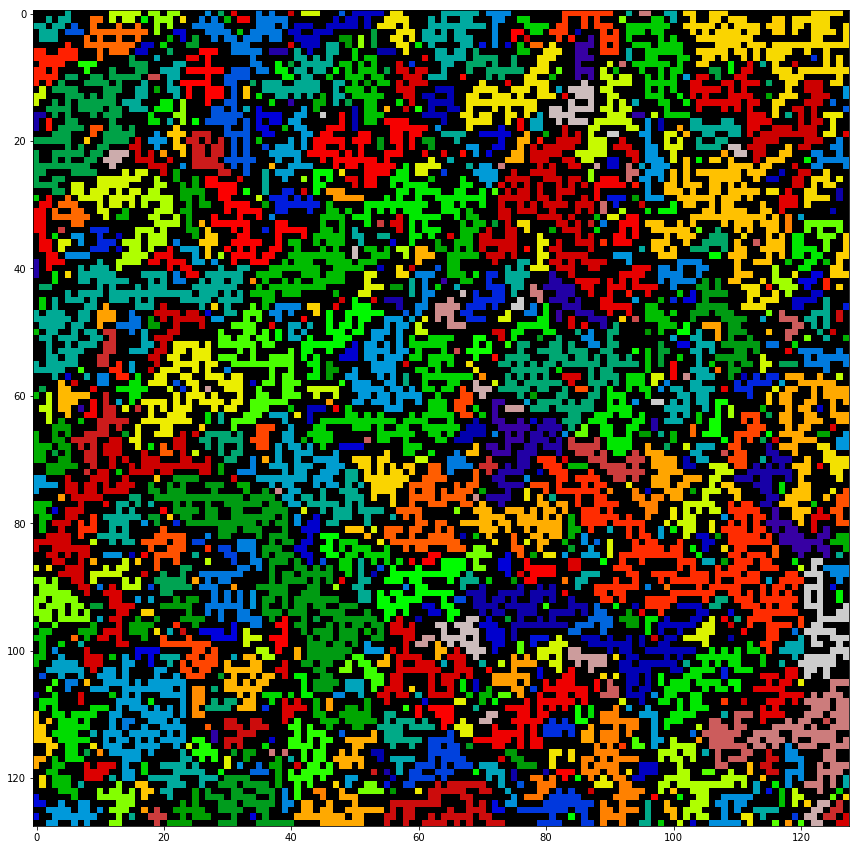

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(shifted_grid, cmap='nipy_spectral')
plt.savefig('groups.png')

In [20]:
group_grid.loc[0:8, 0:8]

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,0,0,0
1,0,0,24,0,1,1,0,0,0
2,1,1,0,1,1,0,38,0,0
3,0,1,1,1,0,38,38,38,0
4,0,1,1,1,0,0,0,0,40
5,0,0,0,0,0,22,0,0,40
6,22,22,0,0,22,22,22,0,0
7,22,22,22,22,22,22,22,0,0
8,0,22,22,22,22,0,0,72,72
